<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Обработка-текста" data-toc-modified-id="Обработка-текста-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Обработка текста</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Лемматизация</a></span></li></ul></li><li><span><a href="#Дисбаланс---downsampling" data-toc-modified-id="Дисбаланс---downsampling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Дисбаланс - downsampling</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#baseline" data-toc-modified-id="baseline-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>baseline</a></span></li><li><span><a href="#catboost-TF-IDF" data-toc-modified-id="catboost-TF-IDF-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>catboost TF-IDF</a></span><ul class="toc-item"><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#BERT---модель-взята-с-HuggingFace" data-toc-modified-id="BERT---модель-взята-с-HuggingFace-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>BERT - модель взята с HuggingFace</a></span></li><li><span><a href="#Итоговое-тестирование-модели" data-toc-modified-id="Итоговое-тестирование-модели-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Итоговое тестирование модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» TDF-IDF and BERT from HuggingFace

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
from transformers import BertTokenizer, BertConfig
import re
import torch
import spacy
from pymystem3 import Mystem
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from catboost import CatBoostClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/artemmm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/artemmm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/artemmm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/artemmm/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/artemmm/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
import os
pth1 = '/Users/artemmm/Downloads/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'
pth3 = '/content/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, usecols=[1, 2])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, usecols=[1, 2])
elif os.path.exists(pth3):
    data = pd.read_csv(pth3, usecols=[1, 2])
else:
    print('Something is wrong')

RANDOMSTATE = 42
#data = data.sample(8000, random_state = RANDOMSTATE)
data.head()
print(data.shape)

(8000, 2)


#### Обработка текста

In [4]:
data['text'] = data['text'].str.replace('\n', ' ')

### BERT - модель взята с HuggingFace

In [5]:
#features_downsampled, target_downsampled = downsample(data['text'], data['toxic'], 0.1)
#data = pd.concat([features_downsampled, target_downsampled], axis = 1)
data = data.sample(400)

data.head()

,text,toxic
85827,""" Kingping said """"Very well, please place any ...",0
117319,Why has my article been put up for deletion. ...,0
79636,[edit] Budokai tenakaichi 2 In what way did I ...,0
154024,An utter fabrication and ridiculous nonsense! ...,1
10388,"No, I'm not. Link was forwarded to me. Please ...",0


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert", do_lower_case = True)
tokenized = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length = 512))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [7]:
batch_size = 20
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0].numpy())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
features = np.concatenate(embeddings)
train, test, y_train, y_test = train_test_split(features,data['toxic'],
                                                test_size = 0.3, shuffle = False,
                                                random_state = RANDOMSTATE)
x_test,x_valid, y_test, y_valid = train_test_split(test, y_test, test_size = 0.5, random_state = RANDOMSTATE)

#features, target = downsample(train, y_train, 0.1)


#model = CatBoostClassifier(eval_metric = 'TotalF1', learning_rate = 0.2)
                           #, verbose=False)
#model.fit(train, y_train, eval_set = (test, y_test))

model = LogisticRegression()
model.fit(train, y_train)
pred = model.predict(x_valid)
print(f1_score(pred, y_valid))
cbc_conf_mtrx = confusion_matrix(y_valid, pred)

1.0


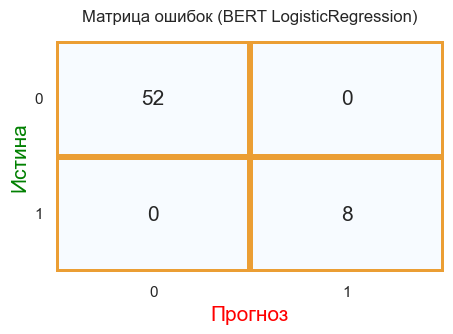

In [9]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.heatmap(cbc_conf_mtrx, ax=ax, annot=True, fmt='n', annot_kws={'fontsize':15},
            cbar=False, linewidths=3, linecolor='#eb9e34', cmap=plt.cm.Blues, center=25000)
ax.set_title('Матрица ошибок (BERT LogisticRegression)', fontsize=12, y=1.05)
ax.tick_params(axis='y', labelrotation=0)
ax.set_xlabel('Прогноз', fontsize = 15, color='red')
ax.set_ylabel('Истина', fontsize = 15, color='green')
plt.show()

### Итоговое тестирование модели

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны